# GAM Pyro Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [216]:
import pandas as pd
import numpy as np
from orbit.models.tkr import TKRFull
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.dataset import load_iclaims, load_electricity_demand

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [136]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [318]:
df = load_electricity_demand()
m = df['electricity'].mean()
df['electricity'] = df['electricity']/m
df['electricity'] = np.log(df['electricity'])
df['tp'] = np.arange(0, len(df))/len(df)
# df, fs_cols = make_fourier_series_df(df, 'date', 365.25, order=10)
df

,date,electricity,tp
0,2000-01-01,-0.32819,0.00000
1,2000-01-02,-0.26449,0.00030
2,2000-01-03,-0.13014,0.00061
3,2000-01-04,-0.11187,0.00091
4,2000-01-05,-0.10490,0.00122
...,...,...,...
3283,2008-12-27,0.25753,0.99848
3284,2008-12-28,0.16131,0.99878
3285,2008-12-29,0.28150,0.99909
3286,2008-12-30,0.29870,0.99939


### Train / Test Split

In [321]:
test_size=365
train_df=df[:-test_size]
test_df=df[-test_size:]

## VI Fit and Predict - Fully Bayesian

Pyro only support Variational Inference(SVI) for full sampling prediction.  Note that `pyro` takes advantage of parallel processing in `vi` and hence result in similar computation time compared to `map`.

In [331]:
tkr = TKRFull(
    response_col='electricity',
    date_col='date',
    regressor_col=['tp'],
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 3],
#     regressor_col=fs_cols + ['trend.unemploy', 'trend.filling', 'trend.job'],
#     regressor_col=fs_cols + ['tp'] + ['trend.unemploy', 'trend.filling', 'trend.job'],
#     regressor_sign=['='] * 7,
    
#     level_knot_scale = 10,
#     regressor_knot_loc=[0] * 7,
#     regressor_knot_scale=[10] * 4,
#     positive_regressor_knot_pooling_scale=0.1,
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.1,
    rho_coefficients=0.2,

    degree_of_freedom=30,
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    learning_rate_total_decay=1.0,
    verbose=True,
    message=100,
    n_bootstrap_draws=-1,
    estimator_type=PyroEstimatorVI,
)

In [333]:
%%time
tkr.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 14533, scale = 0.092108
step  100 loss = -3658.7, scale = 0.013843
step  200 loss = -3589.7, scale = 0.015787
step  300 loss = -3613, scale = 0.018108
step  400 loss = -3664.1, scale = 0.019564
step  500 loss = -3753.7, scale = 0.019261
step  600 loss = -3779, scale = 0.020419
step  700 loss = -3778.4, scale = 0.019572
step  800 loss = -3676.5, scale = 0.02005
step  900 loss = -3754.7, scale = 0.021832
CPU times: user 7min 46s, sys: 15.7 s, total: 8min 2s
Wall time: 1min 11s


In [283]:
# data_input = gam_vi._get_model_data_input()
# data_input

In [305]:
# gam_vi._get_model_param_names()

In [334]:
predicted_df = tkr.predict(df=df, decompose=True)
predicted_df.head()

,date,seasonality_0_5,seasonality_0,seasonality_0_95,seasonality_1_5,seasonality_1,seasonality_1_95,regression_5,regression,regression_95,trend_5,trend,trend_95,prediction_5,prediction,prediction_95
0,2000-01-01,-0.09805,-0.08374,-0.07037,0.04768,0.06302,0.07782,0.00000,0.00000,0.00000,-0.36941,-0.26099,-0.15834,-0.38884,-0.28176,-0.17624
1,2000-01-02,-0.12084,-0.10593,-0.09134,0.04831,0.06354,0.07833,-0.00043,-0.00043,-0.00043,-0.36325,-0.25553,-0.15289,-0.40855,-0.29855,-0.19121
2,2000-01-03,-0.00879,0.00494,0.01765,0.04907,0.06412,0.07925,-0.00087,-0.00087,-0.00087,-0.37030,-0.25910,-0.14974,-0.30190,-0.19250,-0.08215
3,2000-01-04,0.05336,0.06510,0.07661,0.04977,0.06471,0.07958,-0.00130,-0.00130,-0.00130,-0.36400,-0.25439,-0.14968,-0.23646,-0.12565,-0.02336
4,2000-01-05,0.03175,0.04412,0.05558,0.05022,0.06523,0.08014,-0.00173,-0.00173,-0.00173,-0.37332,-0.25894,-0.14718,-0.26584,-0.14998,-0.03938


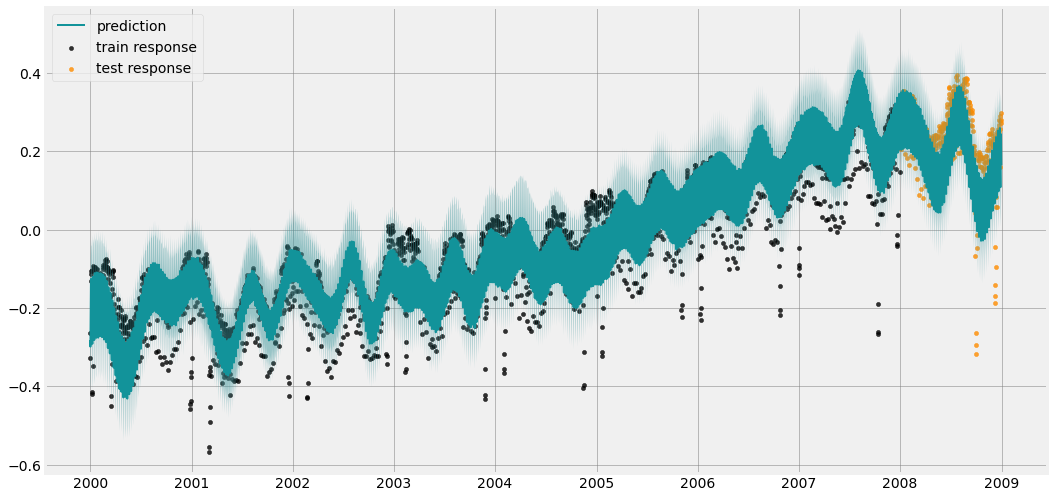

In [335]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='date', actual_col='electricity', 
                    test_actual_df=test_df)

In [326]:
def plot_predicted_components(predicted_df, date_col, prediction_percentiles=None, title="", figsize=None, path=None,
                             plot_components=None):
    """ Plot predicted componenets with the data frame of decomposed prediction where components
    has been pre-defined as `trend`, `seasonality` and `regression`.
    Parameters
    ----------
    predicted_df: pd.DataFrame
        predicted data response data frame. two columns required: actual_col and pred_col. If
        user provide pred_percentiles_col, it needs to include them as well.
    date_col: str
        the date column name
    prediction_percentiles: list
        a list should consist exact two elements which will be used to plot as lower and upper bound of
        confidence interval
    title: str
        title of the plot
    figsize: tuple
        figsize pass through to `matplotlib.pyplot.figure()`
    path: str
        path to save the figure
   Returns
    -------
        None
    """

    _predicted_df=predicted_df.copy()
    _predicted_df[date_col] = pd.to_datetime(_predicted_df[date_col])
    if plot_components is None:
        plot_components = [PredictedComponents.TREND.value,
                           PredictedComponents.SEASONALITY.value,
                           PredictedComponents.REGRESSION.value]

    plot_components = [p for p in plot_components if p in _predicted_df.columns.tolist()]
    n_panels = len(plot_components)
    if not figsize:
        figsize=(16, 8)

    if prediction_percentiles is None:
        _pred_percentiles = [5, 95]
    else:
        _pred_percentiles = prediction_percentiles

    if len(_pred_percentiles) != 2:
        raise ValueError("prediction_percentiles has to be None or a list with length=2.")

    fig, axes = plt.subplots(n_panels, 1, facecolor='w', figsize=figsize)
    for ax, comp in zip(axes, plot_components):
        y = predicted_df[comp].values
        ax.plot(_predicted_df[date_col], y, marker=None, color='#12939A')
        confid_cols = ["{}_{}".format(comp, _pred_percentiles[0]), "{}_{}".format(comp, _pred_percentiles[1])]
        if set(confid_cols).issubset(predicted_df.columns):
            ax.fill_between(_predicted_df[date_col].values,
                            _predicted_df[confid_cols[0]],
                            _predicted_df[confid_cols[1]],
                            facecolor='#42999E', alpha=0.5)
        ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.5)
        ax.set_title(comp, fontsize=16)
    plt.suptitle(title, fontsize=16)
    fig.tight_layout()

    if path:
        plt.savefig(path)

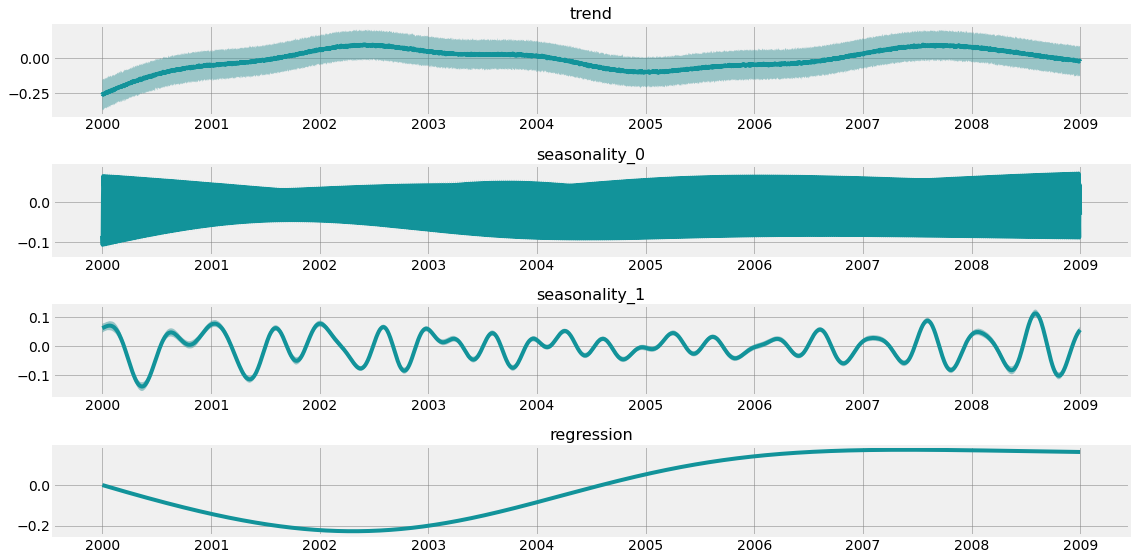

In [336]:
plot_predicted_components(predicted_df, 'date', plot_components=['trend','seasonality_0','seasonality_1','regression'])